In [53]:
import numpy as np
import os
# import cv2
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import tensorflow as tf
from tqdm import tqdm_notebook
import scipy
from scipy.spatial.distance import hamming, cosine
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import math
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import matplotlib.image as mpimg

%matplotlib inline
# tf.compat.v1.disable_eager_execution()

In [33]:
def trainModel():    
    TRAINING_DIR = "Dataset/train"
    training_datagen = ImageDataGenerator(1./255)

    VALIDATION_DIR = "Dataset/test"
    validation_datagen = ImageDataGenerator(1./255)

    train_generator = training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(32,32),
        class_mode='categorical',
      batch_size=256
    )

    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(32,32),
        class_mode='categorical',
      batch_size=256
    )
    

    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # This is the first convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.25),
        # The second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.25),
        # The third convolution,
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.25),
#         # The fourth convolution
#         # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])


    model.summary()
    model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    history = model.fit(train_generator, epochs=50, validation_data = validation_generator, verbose = 1, validation_steps=3)
    return model

Training Model with Cifar-10 dataset

In [ ]:
trained_model = trainModel()  

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 13, 13, 64)        36928     
________________________________

c:\users\knavi\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
193/196 [============================>.] - ETA: 1s - loss: 3.9466 - accuracy: 0.1022

Getting Features

In [107]:
VALIDATION_DIR = "Dataset/test"
validation_datagen = ImageDataGenerator(1./255)
validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(32,32),
        class_mode='categorical',
      batch_size=256
    )
TRAINING_DIR = "Dataset/train"
training_datagen = ImageDataGenerator(1./255)
train_generator = training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(32,32),
        class_mode='categorical',
      batch_size=256
    )
features = trained_model.predict_generator(validation_generator, 40,verbose = 1)

Found 10000 images belonging to 10 classes.
Found 50000 images belonging to 10 classes.


c:\users\knavi\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1937: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
c:\users\knavi\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


40/40 [==============================] - 12s 293ms/step


In [108]:
print("Shape of feature_list = ", features.shape)

Shape of feature_list =  (10000, 10)


Prediction for Image Classification

In [106]:
img = image.load_img('C:/Users/knavi/5_frog.png', target_size=(32, 32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
''
images = np.vstack([x])
classes = trained_model.predict(images)
print(classes)

[[5.4660299e-10 1.6956554e-11 3.9880042e-04 4.2977203e-02 7.0350210e-04
  1.7967992e-02 9.3792593e-01 2.6535336e-05 1.4096242e-12 7.6207707e-10]]


Using NearestNeighbors Algorithm for Reverse Image Search

In [109]:
filenames = [TRAINING_DIR + '/' + s for s in train_generator.filenames]

In [111]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(features)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

Preprocessing input image to fit into our model size format

In [115]:
img_path = 'C:/Users/knavi/417_airplane.png'
input_shape = (32, 32, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)

In [116]:
test_img_features = trained_model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

Getting predictions for similar images

(1, 5)


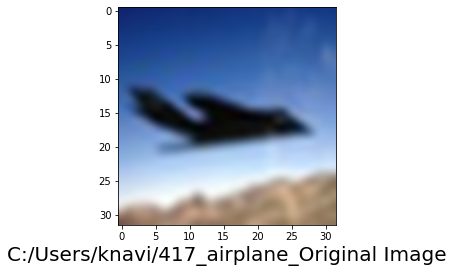

********* Predictions ***********


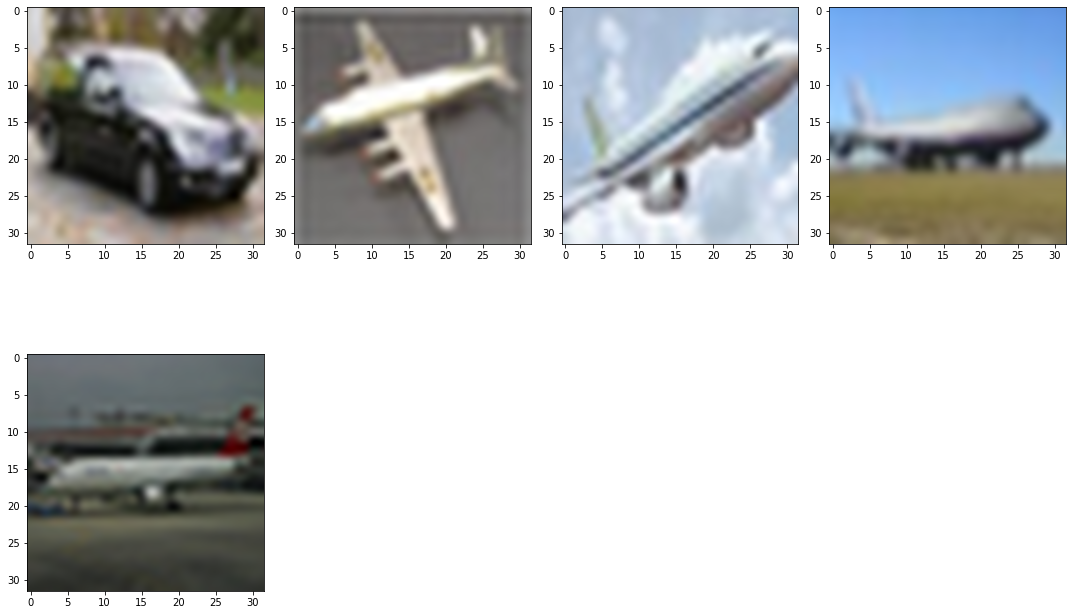

In [117]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])